This is a quick tutorial on how to run the GNN+Flow model on stellar kinematic dataset.

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch_geometric
import yaml

import jeans_gnn as jgnn

%matplotlib inline

## Read the dataset

As a first step, we read the preprocessed dataset of projected galaxy kinematics.
For each galaxy, we will construct a k-nearest neighbor graph.

In [3]:
# Read the training and validation datasets
dataset_path = 'data/example_data.hdf5'
node_features, graph_features, headers = jgnn.utils.dataset.read_graph_dataset(
    dataset_path, features_list=['pos', 'vel', 'labels'])
num_galaxies = headers['num_galaxies']

# print all headers of the training dataset
print('Headers:')
for k, v in headers.items():
    print('- {}: {}'.format(k, v))

Headers:
- all_features: ['pos' 'vel' 'vel_error' 'dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm'
 'dm_rho_0' 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
- dataset_name: mini_gNFW_Plummer_OM_poisson100
- date: 2023-04-14 11:23:34
- df_type: QuasiSpherical
- dm_type: Spheroid
- error_los: 0
- flag: valid
- galaxy_name: mini_gNFW_Plummer_OM_poisson100
- graph_features: ['dm_alpha' 'dm_beta' 'dm_gamma' 'dm_r_dm' 'dm_rho_0'
 'stellar_r_star_r_dm' 'df_beta_0' 'df_r_a_r_star' 'num_stars'
 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_log_r_a' 'labels'
 'original_idx']
- labels_order: ['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
- name: mini
- node_features: ['pos' 'vel' 'vel_error']
- num_galaxies: 100
- projection: 0
- stellar_type: Plummer
- train_frac: 0.9


In this example, there are 100 galaxies. 

Each galaxy has a different number of stars. The node features of each star are:
- `pos`: the 2D position of the galaxy
- `vel`: the line-of-sight velocity of the galaxy
- `vel_err`: the error on the line-of-sight velocity of the galaxy

The labels are stored in `graph_features['labels']`, which is a (N, 6) dimensional
array with label ordering:
- `dm_gamma`: inner slope of the gNFW profile
- `dm_log_r_dm`: the log10 of the scale radius of the gNFW profile
- `dm_log_rho_0`: the log10 of the central density of the gNFW profile
- `stellar_log_r_star`: the log10 of the scale radius of the Plummer profile
- `df_beta_0`: the normalization of the Osipkov-Merritt DF velocity anisotropy
- `df_log_r_a`: the log10 of the scale radius of the Osipkov-Merritt DF

In [4]:
# print the node features of the first 10 stars in the first galaxy
print("Node features:")
print("- pos: {}".format(node_features['pos'][0][:10]))
print("- vel: {}".format(node_features['vel'][0][:10]))

print("Graph features:")
print(headers['labels_order'])
print("- labels: {}".format(graph_features['labels'][0]))

Node features:
- pos: [[ 0.13504457  0.05950324]
 [-0.03729184 -0.151646  ]
 [-0.11927976 -0.11157647]
 [-0.03330625  0.06756137]
 [-0.00840738  0.03095477]
 [ 0.07772832 -0.04542598]
 [-0.06865919 -0.04856362]
 [ 0.02304553  0.0593613 ]
 [ 0.00202816  0.00174576]
 [ 0.10052064  0.04847484]]
- vel: [ 0.29824803 -0.04545442  0.21565156 -0.46745416 -0.20959343 -0.14228842
  0.66527882  0.53476856  0.24639451 -0.36439535]
Graph features:
['dm_gamma' 'dm_log_r_dm' 'dm_log_rho_0' 'stellar_log_r_star' 'df_beta_0'
 'df_log_r_a']
- labels: [ 1.79551026 -0.94841769  6.9007755  -1.12356432 -0.18195041 -0.90968556]


## Sample the DM density profile

### Read in the simulation-based inference model
We will now read in the GNN+Flow model. For this, we will use the `GNNInferenceModel` class from the `JeansGNN` library.

- The `JeansGNN` repo is available at https://github.com/trivnguyen/JeansGNN. It should already be a submodule of this repo. Because the `JeansGNN` repo also includes a tutorial on how to train the GNN+SBI model, we will not go into details here. But feel free to ask me if you have any questions!

- The `GNNInferenceModel` class is a convenient wrapper for the `GraphRegressor` class, which is where the parameters of the neural network are stored. The `GNNInferenceModel` class includes convinience functions for training the model and sampling from the posterior distribution.

As a first step, we will read in the model that uses only the projected radii and the line-of-sight velocities as input features. This is the model that we will use to generate the posterior samples.

In [5]:
model_dir = 'models/gnfw-beta-priorlarge-pois100-cheb-small'
inference_model = jgnn.im.gnn_im.GNNInferenceModel.load_from_dir(run_dir=model_dir)

Now, we will create a dataset for inference. First, we must transform each galaxy into a graph representation. Thankfully, in addition to the GNN+Flow parameters, the `GNNInferenceModel` also stores a transformation object that can be used to transform the dataset into a graph representation.

Note that it is important to keep the transformation (sometimes also known as preprocessing) object around. This is because we will need to transform the test dataset in the same way as the training dataset.

We will now create a `torch_geometric.loader.DataLoader` object. Data loader objects are commonly used in machine learning to load data in batches, which is useful for training neural networks. In this case, we will use the data loader to load the test dataset in batches.

In [6]:
batch_size = 128   # increase this if you have more memory
data_loader = jgnn.utils.dataset.create_dataloader_from_array(
    node_features['pos'], node_features['vel'], inference_model.transform, 
    batch_size=batch_size)

We can now sample the DM density profiles!!! This can be done simply by calling the `sample` method of the `GNNInferenceModel` object.

In [7]:
num_samples = 10000 
posteriors = inference_model.sample(
    num_samples=num_samples, data_loader=data_loader,)

print(posteriors.shape)

(100, 10000, 6)


The posterior distribution has a shape of `(num_galaxies, num_samples, label_dim)`. The labels are, in ordered:
- `dm_gamma`: inner slope of the gNFW profile
- `dm_log_r_dm`: the log10 of the scale radius of the gNFW profile
- `dm_log_rho_0`: the log10 of the central density of the gNFW profile
- `df_beta_0`: the normalization of the Osipkov-Merritt DF velocity anisotropy
- `df_log_r_a`: the log10 of the scale radius of the Osipkov-Merritt DF
- `stellar_log_r_star`: the log10 of the scale radius of the Plummer profile

IMPORTANT: Note that this is slightly different from the order of the label in the dataset. This is because the training dataset I used for this model has a different label ordering. This is currently a drawback of the `GNNInferenceModel` class. I will fix this in the future.

### Plotting the posterior samples

We use the `corner` package to plot the corner plot of the predicted
DM density and the truth DM density.

API Reference for `corner` package: https://corner.readthedocs.io/en/latest/

In [9]:
import corner

In [10]:
truths = graph_features['labels']

# because of the issues with the order of the labels (mentioned above), we need to reorder the truths
truths[:, [3, 4, 5]] = truths[:, [4, 5, 3]]

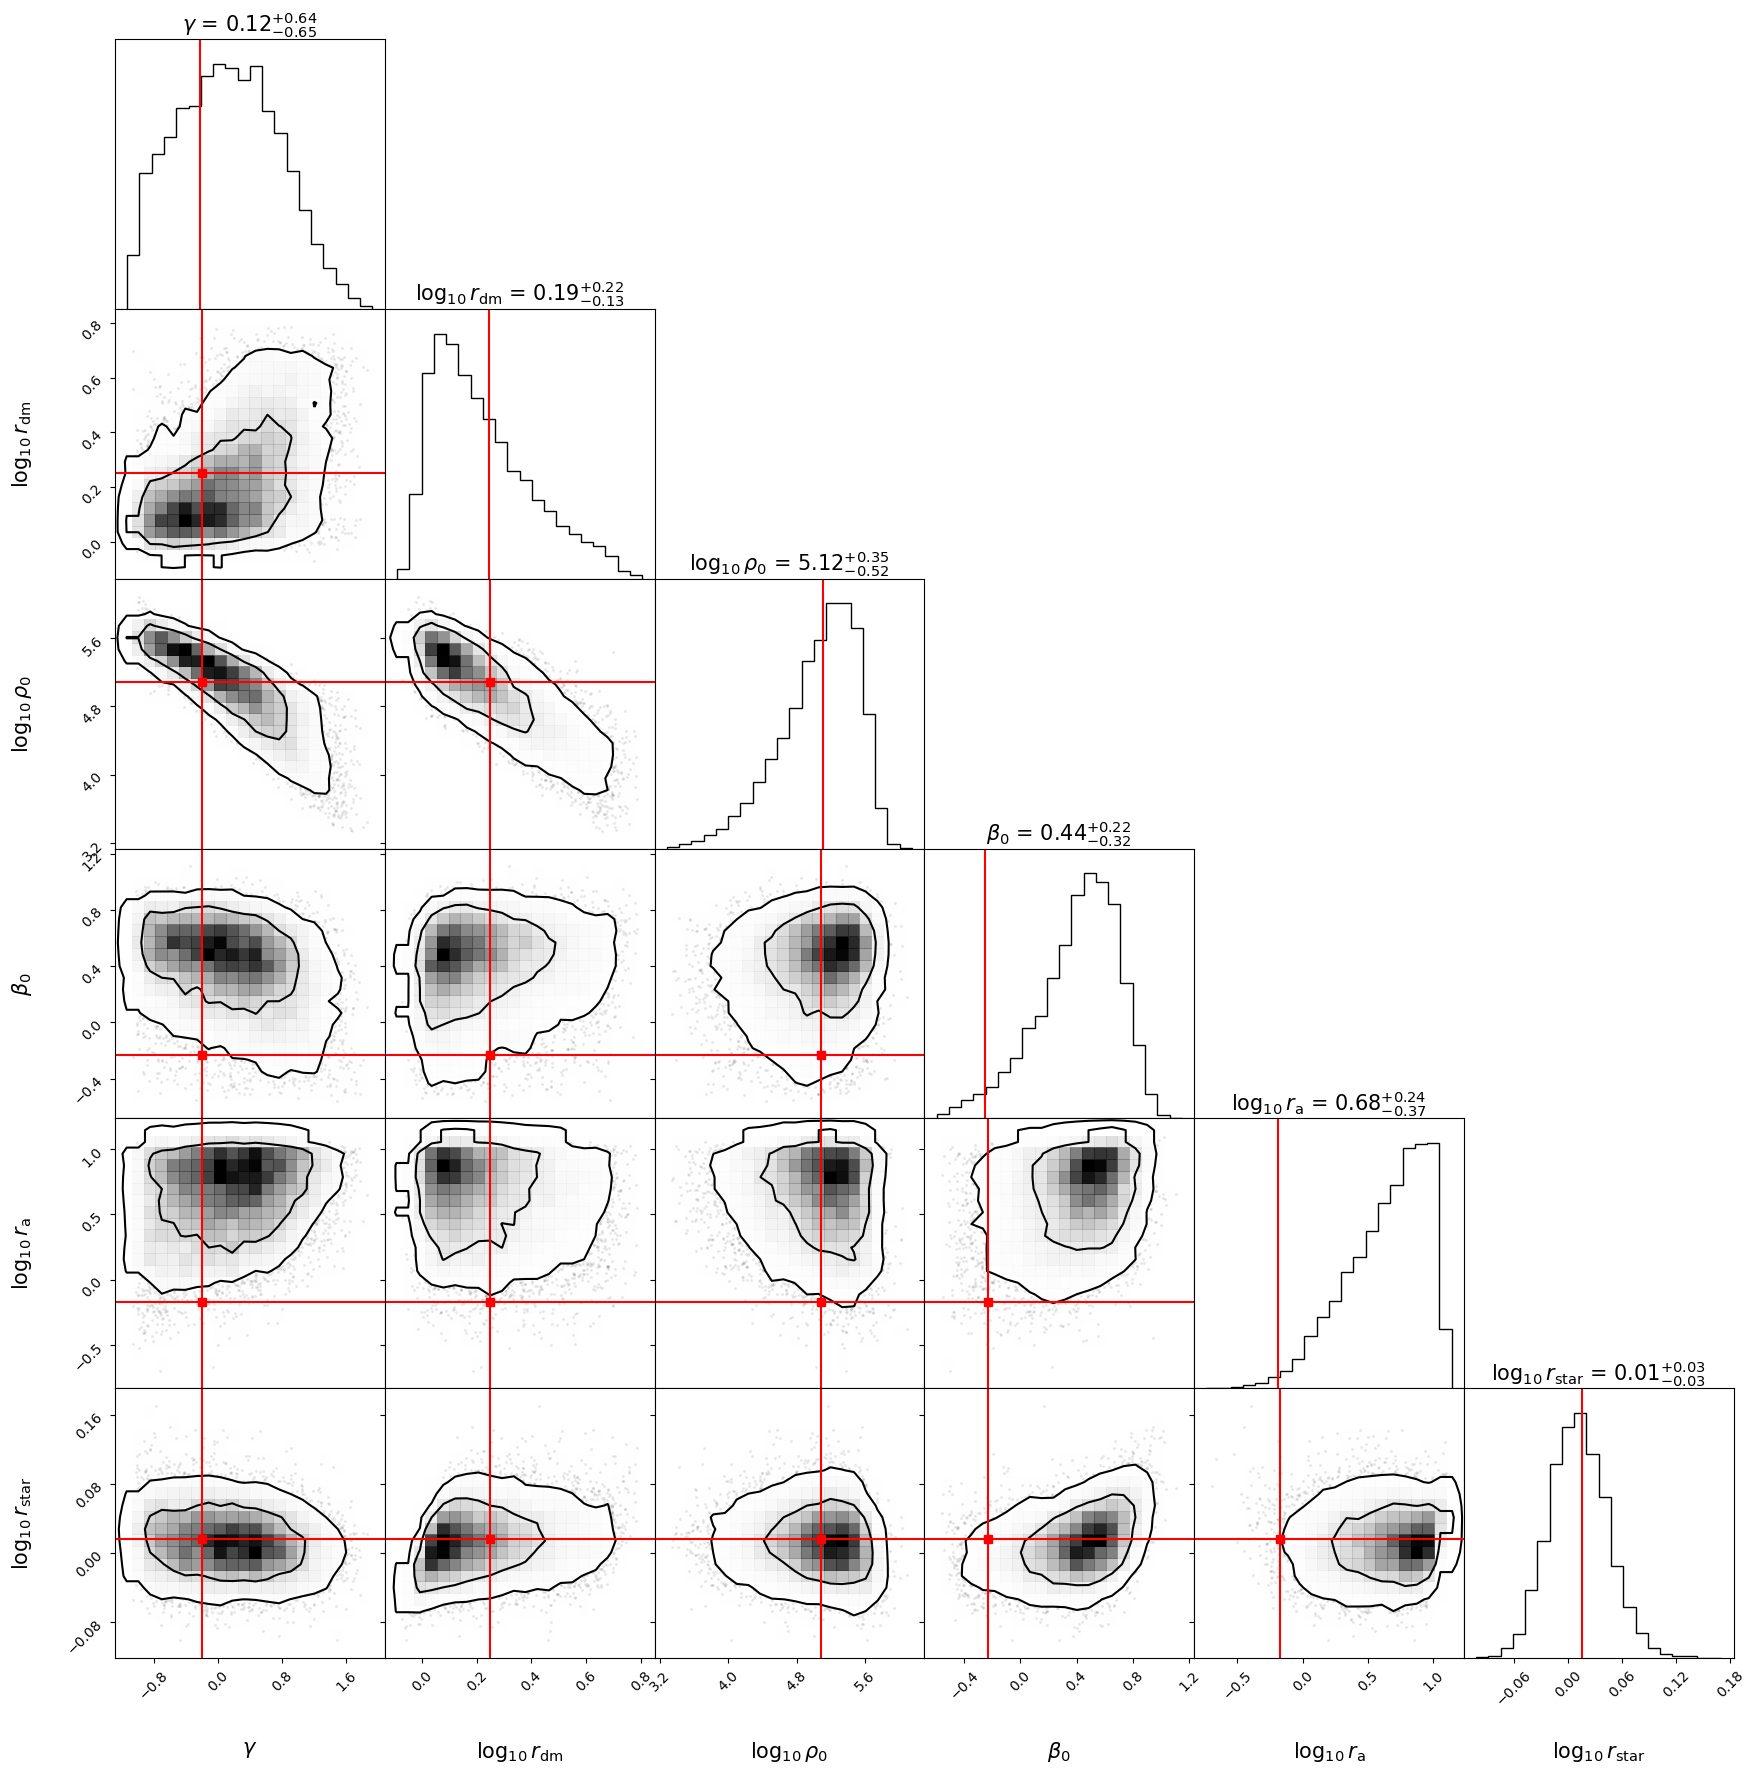

In [39]:
# plot corner plot of a chosen idx
idx = 9
labels = [
    r'$\gamma$', r'$\log_{10} r_{\rm dm}$', r'$\log_{10} \rho_0$', 
    r'$\beta_0$', r'$\log_{10} r_{\rm a}$', r'$\log_{10} r_{\rm star}$', 
]
corner_args =dict(
    truth_color='red',
    labels=labels,
    show_titles=True,
    title_kwargs={'fontsize': 15},
    label_kwargs={'fontsize': 15},
    smooth=0.5,
    levels=(0.68, 0.95),
)

fig = plt.figure(figsize=(18, 18))
fig = corner.corner(
    posteriors[idx], truths=truths[idx],
    fig=fig, **corner_args
)
fig.subplots_adjust(wspace=0, hspace=0)